Exercise: AL Connectivity stereotypy

In [469]:
import pandas as pd
import numpy as np
import seaserpent as ss

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import math 

from fafbseg import flywire
import navis
import pickle
from navis import utils
%env SEATABLE_TOKEN = 59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
%env SEATABLE_SERVER = https://flytable.mrc-lmb.cam.ac.uk/

env: SEATABLE_TOKEN=59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
env: SEATABLE_SERVER=https://flytable.mrc-lmb.cam.ac.uk/


# set up - please don't re-run

a. Read AL_library/AL_bodies seatable and extract all ALLNs (cell_class) - select only those that have initials in the checked column and don’t have “messy” in the comments column (there shouldn’t be any).

In [88]:
AL_table_og = ss.Table(table='AL_bodies')
AL_table = AL_table_og.to_frame()
AL_table.reset_index()

,index,root_id,checked_by,pos_x,pos_y,pos_z,supervoxel,comments,cell_class,cell_type,...,AL_L_pre,AL_L_total,total,total_pre,total_post,AL_pre_frac,AL_post_frac,upn_sparseness,frac_to_upns,root_duplicated
0,0,720575940629315958,ASB,120728.0,88360.0,2617.0,78888860116969946,Bilateral\n\n\n\n\n,ALLN,None,...,7563.0,14441.0,29951.0,16244.0,14100.0,0.988796,0.985035,0.618231,0.060889,False
1,1,720575940605654402,None,157640.0,62296.0,751.0,81490785396413563,None,ALLN,None,...,15757.0,29141.0,29141.0,15817.0,13440.0,0.996207,0.995833,0.558913,0.063464,False
2,2,720575940618166321,None,104232.0,57736.0,991.0,77760898357374019,None,ALLN,None,...,0.0,0.0,29055.0,15226.0,13961.0,0.994877,0.996132,0.589349,0.069976,True
3,3,720575940610800882,None,104584.0,59384.0,1119.0,77831404607694577,None,ALLN,None,...,0.0,0.0,28800.0,14459.0,14508.0,0.995781,0.992694,0.592493,0.071538,False
4,4,720575940615433558,None,157544.0,61552.0,557.0,81420347932538686,None,ALLN,None,...,17925.0,28506.0,28506.0,18186.0,10704.0,0.985648,0.988509,0.556176,0.048424,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18835,18835,720575940616364545,GB,153261.0,65649.0,301.0,81139147766640924,None,RN,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
18836,18836,720575940619073195,GB,111628.0,57129.0,532.0,78323848310719483,None,RN,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
18837,18837,720575940617220160,GB,110287.0,55394.0,565.0,78182973383386563,None,RN,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
18838,18838,720575940628604727,GB,154725.0,56447.0,247.0,81279266779589162,None,RN,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [89]:
all_ALLNs = AL_table[AL_table.cell_class=='ALLN']
all_ALLNs.shape

(665, 30)

In [98]:
new_roots = []
for ind in all_ALLNs.index:
    vox = all_ALLNs.loc[ind].supervoxel
    if vox:
        try:
            new_roots.append(flywire.supervoxels_to_roots(vox)[0])
        except:
            try:
                new_roots.append(all_ALLNs.loc[ind].root_id)
            except:
                pass
    elif all_ALLNs.loc[ind].root_id:
        new_roots.append(all_ALLNs.loc[ind].root_id)

In [99]:
# checked_ALLNs = all_ALLNs.dropna(subset=['checked_by'])
# checked_ALLNs.shape

b. Find downstream partners of ALLNs.


In [103]:
all_down_1 = flywire.fetch_connectivity(new_roots[:330], upstream=False, batch_size=10, live_query=True)

Fetching connectivity:   0%|          | 0/33 [00:00<?, ?it/s]

In [106]:
all_down_2 = flywire.fetch_connectivity(new_roots[330:390], upstream=False, batch_size=10, live_query=True)

Fetching connectivity:   0%|          | 0/6 [00:00<?, ?it/s]

In [508]:
all_down_3 = flywire.fetch_connectivity(new_roots[390:], upstream=False, batch_size=10, live_query=False)

Fetching connectivity:   0%|          | 0/28 [00:00<?, ?it/s]

In [121]:
all_down = all_down_1.append(all_down_2).append(all_down_3)

In [125]:
all_pres = list(set(all_down.pre))

In [506]:
len(all_pres)

478

In [126]:
conns_pick = open('conns', 'wb')
pickle.dump(all_down, conns_pick)
conns_pick.close()

c. Group ALLNs morphologically.

In [127]:
dps = flywire.l2_dotprops(all_pres)

Fetching L2 IDs:   0%|          | 0/478 [00:00<?, ?it/s]

Fetching L2 vectors:   0%|          | 0/527467 [00:00<?, ?it/s]

Creating dotprops:   0%|          | 0/478 [00:00<?, ?it/s]

In [ ]:
# dps_pick = open('dps','rb')
# #conn_pick = open('conns','rb')
# dps = pickle.load(dps_pick)
# dps_pick.close()

In [135]:
dps_pick = open('dps','wb')
pickle.dump(dps_um,dps_pick)
dps_pick.close()

In [ ]:
# dps.remove_duplicates(inplace=True, key = "id")

In [128]:
dps_um = dps / (1000 / 8)

Dividing:   0%|          | 0/478 [00:00<?, ?it/s]

In [136]:
nbl = navis.nblast_allbyall(dps_um)
nbl

Preparing:   0%|          | 0/4 [00:00<?, ?it/s]

NBlasting:   0%|          | 0/239 [00:00<?, ?it/s]


NBlasting:   0%|          | 0/239 [00:00<?, ?it/s]

NBlasting:   1%|▏         | 3/239 [00:00<00:08, 26.86it/s]

NBlasting:   0%|          | 1/239 [00:00<00:30,  7.81it/s]


NBlasting:   0%|          | 1/239 [00:00<00:41,  5.80it/s]

NBlasting:   1%|▏         | 3/239 [00:00<00:19, 12.20it/s]


NBlasting:   1%|▏         | 3/239 [00:00<00:22, 10.52it/s]

NBlasting:   2%|▏         | 5/239 [00:00<00:16, 14.47it/s]


NBlasting:   3%|▎         | 6/239 [00:00<00:23,  9.84it/s]

NBlasting:   3%|▎         | 6/239 [00:00<00:24,  9.46it/s]


NBlasting:   3%|▎         | 8/239 [00:00<00:20, 11.55it/s]

NBlasting:   4%|▍         | 10/239 [00:00<00:20, 11.28it/s]


NBlasting:   4%|▍         | 10/239 [00:01<00:30,  7.51it/s]

NBlasting:   4%|▍         | 10/239 [00:01<00:33,  6.86it/s]


NBlasting:   5%|▌         | 12/239 [00:01<00:27,  8.19it/s]

NBlasting:   5%|▌         | 12/239 [00:01<00:29,  7.69it/s]


NBlasting:   6%|▌         | 14/239 [00:01<0

,720575940624613376,720575940625231872,720575940606267403,720575940621508621,720575940623437838,720575940626294805,720575940610895894,720575940632305689,720575940616538141,720575940616394786,...,720575940632076243,720575940621170653,720575940613705695,720575940631558113,720575940611098595,720575940636753897,720575940611960813,720575940619988980,720575940628735993,720575940629239803
720575940624613376,1.000000,-0.837664,-0.882161,-0.175549,-0.850861,-0.880363,-0.862387,-0.881543,-0.882097,-0.272289,...,0.316900,-0.115277,-0.880944,-0.881127,-0.880169,-0.879711,-0.880224,-0.882699,-0.730524,-0.859609
720575940625231872,-0.855296,1.000000,-0.880320,-0.527556,-0.799130,-0.881782,-0.882639,-0.656087,-0.816323,-0.268243,...,-0.516578,-0.402079,-0.519959,-0.882310,-0.880646,-0.881114,-0.881484,-0.880527,-0.605662,-0.696538
720575940606267403,-0.880755,-0.881935,1.000000,-0.881352,-0.880965,-0.469865,-0.297847,-0.881567,-0.880849,-0.882256,...,-0.880610,-0.881902,-0.881177,-0.881463,-0.661875,-0.377225,-0.864925,-0.787128,-0.880871,-0.881513
720575940621508621,-0.877395,-0.874432,-0.881198,1.000000,-0.783950,-0.881397,-0.853566,-0.784535,-0.813563,-0.232532,...,-0.608632,-0.348430,-0.321812,-0.827069,-0.864096,-0.881591,-0.882089,-0.881564,-0.739310,-0.571351
720575940623437838,-0.878935,-0.872008,-0.881574,-0.429805,1.000000,-0.831147,-0.779782,-0.776458,-0.784258,-0.411321,...,-0.621890,-0.465493,-0.481537,-0.812057,-0.881603,-0.819400,-0.870621,-0.881552,-0.670510,-0.591690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720575940636753897,-0.880777,-0.881909,-0.821080,-0.881608,-0.870535,-0.370796,-0.825196,-0.881678,-0.881373,-0.876171,...,-0.880711,-0.881583,-0.881225,-0.881302,-0.768803,1.000000,-0.814875,-0.720276,-0.852101,-0.881617
720575940611960813,-0.882013,-0.881699,-0.869419,-0.881488,-0.867336,-0.401827,-0.832081,-0.881949,-0.879983,-0.882237,...,-0.881438,-0.880478,-0.881104,-0.881227,-0.644308,-0.265938,1.000000,-0.678064,-0.865395,-0.881960
720575940619988980,-0.880917,-0.881852,-0.838305,-0.881365,-0.881684,-0.479344,-0.845440,-0.881953,-0.881193,-0.881330,...,-0.880910,-0.881387,-0.881311,-0.881378,-0.583498,-0.316374,-0.827857,1.000000,-0.773464,-0.880837
720575940628735993,-0.871330,-0.849640,-0.881254,-0.450566,-0.727181,-0.810051,-0.875760,-0.755356,-0.818484,-0.359557,...,-0.590836,-0.480190,-0.550250,-0.777386,-0.806909,-0.784404,-0.877401,-0.815223,1.000000,-0.552307


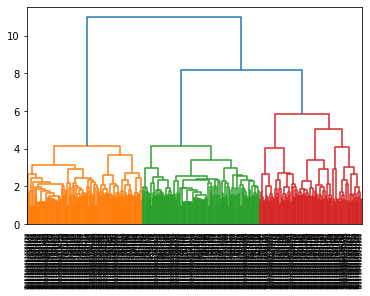

In [132]:
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from scipy.spatial.distance import squareform 
scores = nbl.copy()
# Assuming "scores" are your NBLAST similarity scores
# First: make matrix symmetric
scores = (scores + scores.T.values) / 2

# Then turn similarity into distances 
dists = (scores - 1) * -1

# Turn square- into vector form
vec = squareform(dists)

# Create linkage
Z = linkage(vec, method='ward')

# Plot dendrogram
dn = dendrogram(Z, labels=scores.index.values)

cl = fcluster(Z, t=9, criterion='maxclust')

In [140]:
dps['clust'] = cl


d. Assess connectivity stereotypy from ALLNs to downstream partners - Plot normalised synapse count to downstream partners per ALLN morphological group.

In [262]:
colors = ['blue', 'red', 'green', 'purple', 'yellow', 'orange', 'cyan', 'magenta', 'lime']

In [263]:
color_match = [colors[x-1] for x in cl]

In [264]:
col_dict = dict(zip(all_pres, color_match))

In [137]:
conn_pick = open('conns','rb')
conns = pickle.load(conn_pick)
conn_pick.close()

In [509]:
conns = conns[conns.weight>3]

In [510]:
means = conns.groupby(['pre']).mean().weight
stds = conns.groupby(['pre']).sem().weight

In [511]:
strength = pd.DataFrame(columns=['id', 'avg', 'stds', 'cl'])

In [512]:
strength.id = conns.groupby(['pre']).mean().index
strength.avg = [means.loc[x] for x in strength.id]
strength['stds'] = [stds.loc[x] for x in strength.id]
strength.cl = [col_dict[x] for x in strength.id]
strength = strength.sort_values(by=['cl'])

In [513]:
strength

,id,avg,stds,cl
0,720575940590912819,4.400000,0.244949,blue
155,720575940618033200,6.000000,0.640723,blue
156,720575940618065457,12.950820,2.570345,blue
445,720575940638141811,20.704225,2.051805,blue
162,720575940618165589,13.964912,1.064263,blue
...,...,...,...,...
180,720575940619007664,20.192308,6.701554,yellow
401,720575940632368992,9.173913,0.723918,yellow
210,720575940620102988,8.341772,0.987735,yellow
209,720575940620094633,9.857143,1.079891,yellow


Text(0.5, 1.0, 'avg connection strength per ALLN per morphological group w/ std err')

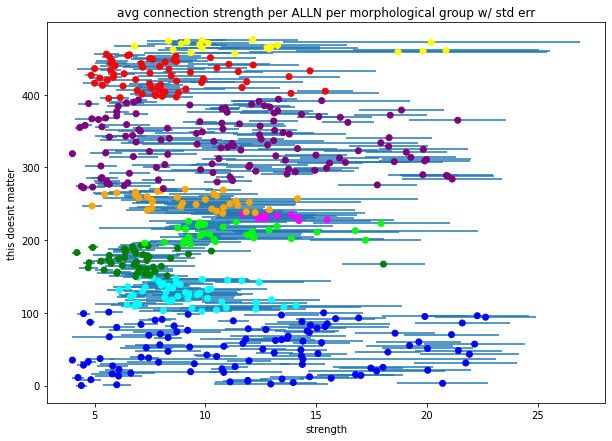

In [515]:
fig = plt.figure()
fig.set_size_inches(10, 7)
ax = plt.axes()
ax.scatter(strength.avg, np.arange(477),  c=list(strength.cl))
ax.errorbar(strength.avg, np.arange(477),  xerr=strength.stds, zorder=0, fmt="none", marker=None)
ax.set_xlabel('strength')
ax.set_ylabel('this doesnt matter')
ax.set_title('avg connection strength per ALLN per morphological group w/ std err')


e. Plot morphological groups in different colours in a flywire scene.

In [485]:
flywire.encode_url(strength.id, seg_colors = col_dict)

'https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6745983232770048'


f. Plot locations of synapse clouds per morphological groups of ALLNs, divided by dendritic and axonal arbors. Do specific morphological groups innervate specific areas of the AL?

In [463]:
blues = strength[strength.cl=='blue'].iloc[10:20].id
magentas = strength[strength.cl=='magenta'].iloc[:10].id
cyans = strength[strength.cl=='cyan'].iloc[10:20].id
greens = strength[strength.cl=='green'].iloc[10:20].id
limes = strength[strength.cl=='lime'].iloc[:10].id
oranges = strength[strength.cl=='orange'].iloc[19:29].id
purples = strength[strength.cl=='purple'].iloc[[1,4,5,7,8,12,13,14,15,16]].id
reds = strength[strength.cl=='red'].iloc[:10].id
yellows = strength[strength.cl=='yellow'].iloc[:10].id

In [464]:
sample_ids = np.asarray([blues, magentas, cyans, greens, limes, oranges, purples, reds, yellows]).flatten()

In [468]:
sample_syns = flywire.fetch_synapses(sample_ids)

In [475]:
xs = sample_syns.pre_x
ys = sample_syns.pre_y
zs = sample_syns.pre_z
cols = [col_dict[sample_syns.loc[x].pre] if sample_syns.loc[x].pre in sample_ids else col_dict[sample_syns.loc[x].post] for x in sample_syns.index]

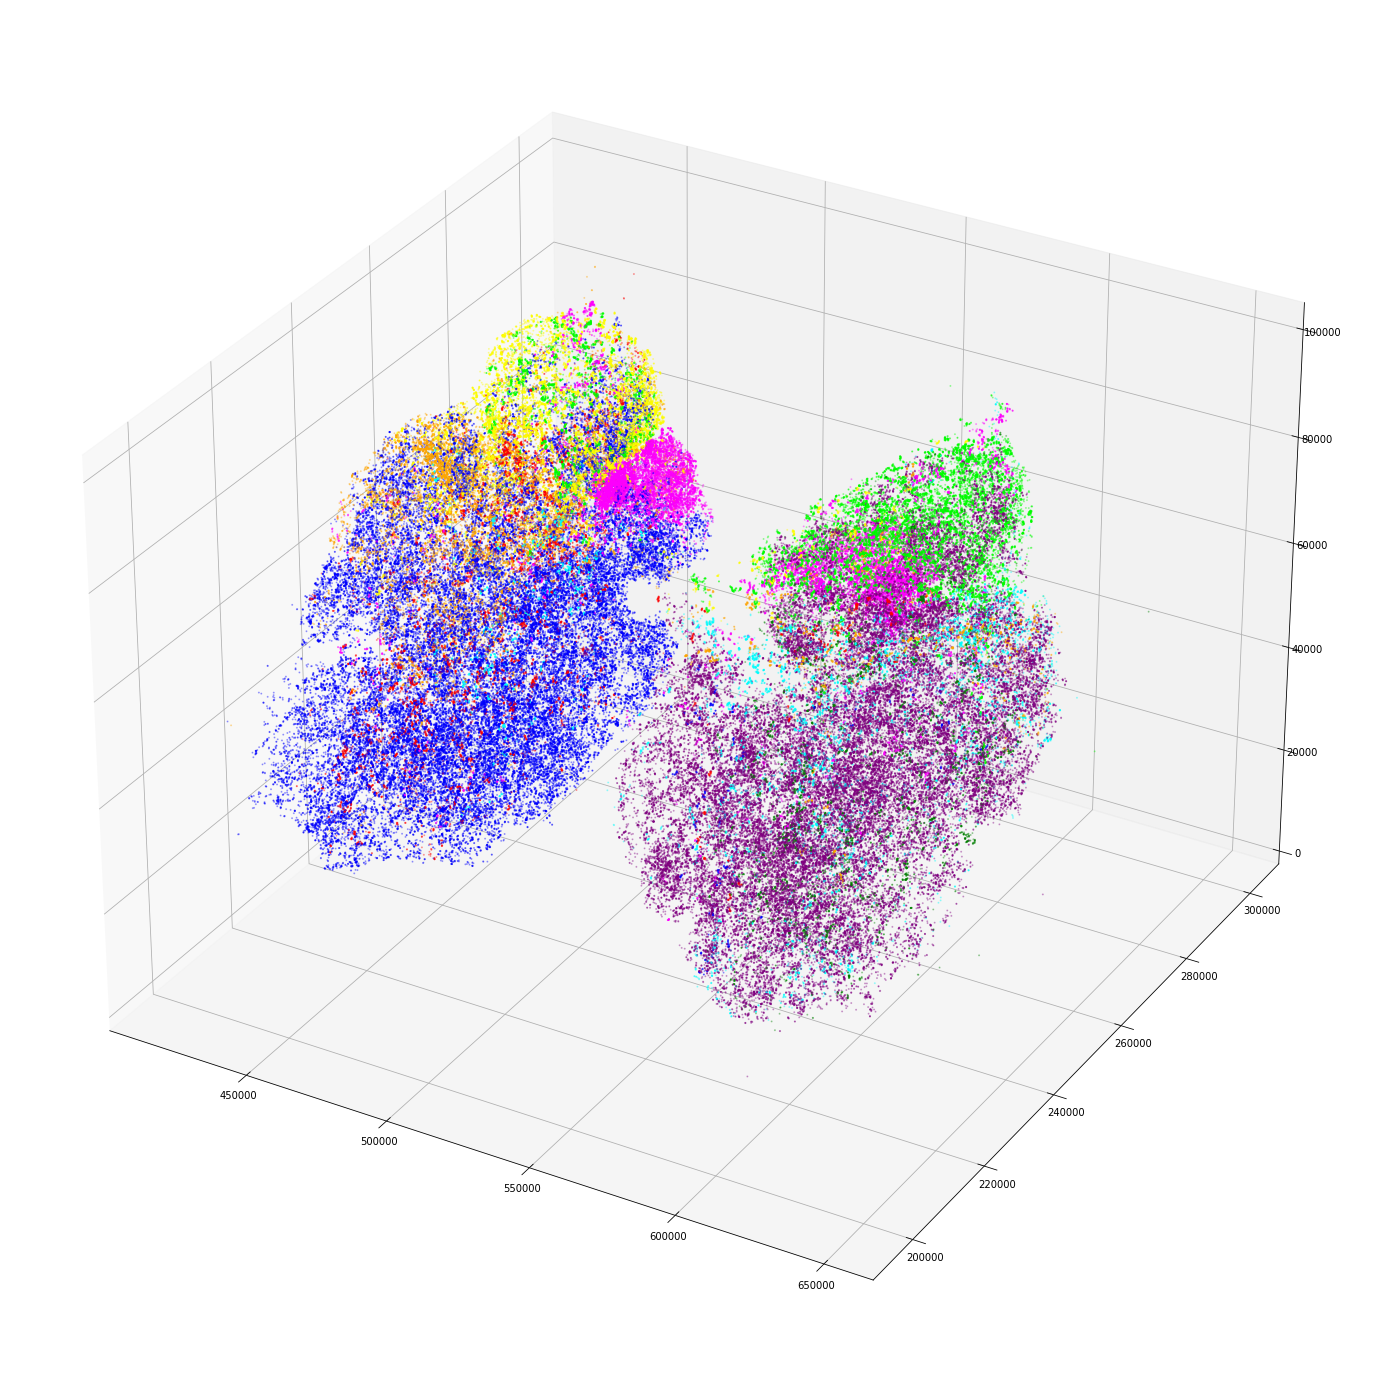

In [488]:
fig = plt.figure()
fig.set_size_inches(25, 25)
ax = plt.axes(projection='3d')
ax.scatter3D(xs, ys, zs, c=cols, s=1, alpha=.3)

YES!